In [14]:
import pandas as pd
import itertools
import re
from random import shuffle
from itertools import combinations
import random
import json
import numpy as np
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Data and preprosses

In [15]:
f = open('TVs-all-merged2.json')
data = json.load(f)
f.close()

In [16]:
dataframe = pd.json_normalize(data).transpose()
model_id = []
features = []
title = []
shop = []
for i in range(len(dataframe)):
    for j in range(len(dataframe[0][i])):
        model_id.append(dataframe[0][i][j]['modelID'])
        features.append(dataframe[0][i][j]['featuresMap'])
        title.append(dataframe[0][i][j]['title'])
        shop.append(dataframe[0][i][j]['shop'])

In [17]:
df= pd.DataFrame()
df['model_id'] = model_id
df['features'] = features
df['title'] = title
df['shop'] = shop

In [18]:
# Making one column with the title and values of the features dictionary/
# Removing words that occur often in title for one shop and other punctuation marks and set everythig to lower case. 
df['titlefeatures'] = df[['title','features']].apply(lambda x : f'{x[0]}{x[1].values()}', axis=1)
df['titlefeatures'] = df['titlefeatures'].apply(lambda x: x.lower().replace('newegg.com','').replace('best buy', '')
                                                 .replace('/', '').replace('-', '').replace('class', '').replace('yes', '')
                                                 .replace("\', \'", " ").replace("([\'", " "). replace("\'])", "")
                                               .replace(';', '').replace('dict_values', ''))


# Functions

In [2]:
# Function that makes shingles of ngrams.
def get_shingles(text, ngram):
    shingles = set(text[head:head + ngram] for head in range(0, len(text) - ngram))
    return shingles

In [3]:
# Function that makes vocabulary of all shingles, needed to make the binary vectors.
def get_vocab(shingle_sets):
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

In [4]:
# Funstion that makes the binary vectors.
def get_binary_vector(shingles, vocab):
    vec = np.zeros(len(vocab))
    for shingle in shingles:
        idx = vocab[shingle]
        vec[idx] = 1
    return vec

In [5]:
# Random permutation minhashing function, n hash functions.
def minhashing(vocab, n):
    length = len(vocab.keys())
    arr = np.zeros((n, length))
    for i in range(n):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
    return arr.astype(int)

In [6]:
# Function that makes the signatures from the minhash function, signatures needen for the input of LSH.
def get_signature(minhash, vector):
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    shingles = minhash[:, idx]
    # find minimum value in each hash vector
    signature = np.min(shingles, axis=1)
    return signature

In [7]:
# Function that performs LSH, divides the observations into buckets. 
# Observations with high similarity are put in the same buckets.
def get_lsh_buckets(signatures, b):
    buckets = []
    counter = 0
    for i in range(b):
        buckets.append({})
    for signature in signatures:
        # Make subvecs
        n = len(signature)
        assert n % b == 0
        r = int(n / b)
        t = (1 / b) ** (1 / r)
        # Break into r rows an b bands
        subvecs = []
        for i in range(0, n, r):
            subvecs.append(signature[i:i+r])
        subvecs = np.stack(subvecs).astype(str)
        # Populate buckets 
        for i, subvec in enumerate(subvecs):
            subvec = ','.join(subvec)
            if subvec not in buckets[i].keys():
                buckets[i][subvec] = []
            buckets[i][subvec].append(counter)
        counter += 1
    return buckets

In [8]:
# Function that makes candidate pairs of the buckets from LSH.
def get_candidates(buckets, boot):
    candidates = []
    for bucket_band in buckets:
        keys = bucket_band.keys()
        for bucket in keys:
            hits = bucket_band[bucket]
            if len(hits) > 1:
                for cand in combinations(hits, 2):
                    # Get only cendidate pairs not from the same website
                    if boot.at[cand[0],'shop'] != boot.at[cand[1],'shop']:
                        candidates.append(cand)
            
    return set(candidates)

In [9]:
# Function that calculates the Jaccard similarity between two observations.
# Input is the binary vector, because that has the same length for every observation. 
# If only shingles of tokens where used, then the union is larger if one observation has a longer title or more features.
def Jac(s1, s2, vocab):
    t1 = get_shingles(s1, 3)
    t2 = get_shingles(s2, 3)
    b1 = get_binary_vector(t1, vocab)
    b2 = get_binary_vector(t2, vocab)
    jac = jaccard_score(b1,b2)
    return jac 

In [10]:
# Function that calculates the cosine similarity between two binary vectors. 
def Cos(s1, s2, vocab):
    t1 = get_shingles(s1, 3)
    t2 = get_shingles(s2, 3)
    b1 = get_binary_vector(t1, vocab)
    b2 = get_binary_vector(t2, vocab)
    cosine = scipy.spatial.distance.cosine(b1, b2)
    cos = 1 - cosine # Similarity is 1 - distance
    return cos

# LSH for different values of b & visuals 

In [34]:
# Set shingle size
k = 3  

# Get shingles
titles = df['titlefeatures']
shingles = []
for title in titles:
    shingles.append(get_shingles(title, k))

# Get vocabulary
vocab = get_vocab(shingles)

# Get binary vectors 
shingles_1hot = []
for shingle_set in shingles:
    shingles_1hot.append(get_binary_vector(shingle_set, vocab))
# Make binary vectors of each title and feature values
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape

(1624, 11290)

In [35]:
# Get minhashing, 100 hash functions
hhash = minhashing(vocab, 100)

# Get signatures
signatures = []

for vector in shingles_1hot:
    signatures.append(get_signature(hhash, vector))

# Merge signatures into single array
signatures = np.stack(signatures)

In [37]:
# For loop that calculates pair completeness and pair quality for different values of b
n_obs = len(df) 
n_dup = 387 # Max number of candidate pairs
b_list = [20,25,50,100] # List of different b's, b=5 and b=10 did not return candidate pairs, therefore omitted.
N_c = [] # Number of comparisons made
D_f = [] # Amount of duplicates found
D_n = [n_dup,n_dup,n_dup,n_dup] 
F_c = [] # Fraction of comparisons 
for b in b_list:
    buckets_b = get_lsh_buckets(signatures,b)
    candidates_b = get_candidates(buckets_b, df)
    nc_ = len(candidates_b)
    N_c.append(nc_)
    fc = nc_/783327 # Assuming that one web shop does not have duplicates (773*(668+163+20)+668*(163+20)+163*20)
    F_c.append(fc)
    data_b = []
    for c in candidates_b: # Makes dataframe for candidate pairs
        r = {"pair": c,
             "model_id0": df.at[c[0], 'model_id'],
             "model_id1": df.at[c[1], 'model_id'],
             "shop0": df.at[c[0], 'shop'],
             "shop1": df.at[c[1], 'shop'],
             "features0": df.at[c[0], 'features'],
             "features1": df.at[c[1], 'features'],
             "title0": df.at[c[0], 'title'],
             "title1": df.at[c[1], 'title'],
             "titlefeature0": df.at[c[0], 'titlefeatures'],
             "titlefeature1": df.at[c[1], 'titlefeatures'],
             "duplicate": (df.at[c[0], 'model_id'] == df.at[c[1], 'model_id'])} # Makes column with True/False if duplicate of not
        data_b.append(r)
    df_candidate_b = pd.DataFrame(data_b) 
    Df_ = df_candidate_b['duplicate'].value_counts()[1] # Gives number of True duplicates
    D_f.append(Df_)

In [38]:
# Print the values of the claculates values needed for F1*
print(N_c)
print(F_c)
print(D_f)
print(D_n)

[80, 1515, 175442, 775531]
[0.00010212848529413641, 0.0019340581902577085, 0.22397032146217352, 0.9900475791080864]
[2, 15, 245, 387]
[387, 387, 387, 387]


In [39]:
# Calculates and print pair quality
pq = []
for i in range(len(D_f)):
    pq_ = D_f[i]/N_c[i]
    pq.append(pq_)

pq

[0.025, 0.009900990099009901, 0.0013964729084255765, 0.0004990129343636811]

In [40]:
# Calculate and print pair completeness 
pc = []
for j in range(len(D_f)):
    pc_ = D_f[j]/D_n[j]
    pc.append(pc_)
    
pc

[0.00516795865633075, 0.03875968992248062, 0.6330749354005168, 1.0]

In [41]:
# Calculate and print F1* 
f1_lsh = []
for l in range(len(pc)):
    f1_lsh_ = (2 * pq[l] * pc[l])/(pq[l] + pc[l])
    f1_lsh.append(f1_lsh_)
    
f1_lsh

[0.008565310492505354,
 0.015772870662460567,
 0.002786798537215135,
 0.0009975280893084063]

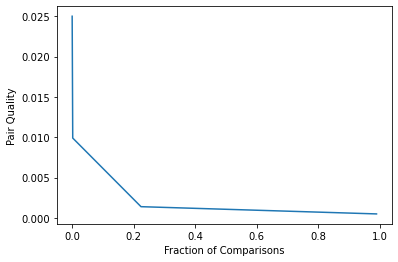

In [42]:
# Plots pair quality with respect to fraction of comparisons
plt.plot(F_c, pq)
plt.ylabel('Pair Quality')
plt.xlabel('Fraction of Comparisons')
plt.show()

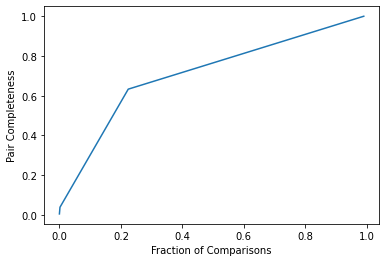

In [44]:
# Plots pair completeness with respect to fraction of comparisons
plt.plot(F_c, pc)
plt.ylabel('Pair Completeness')
plt.xlabel('Fraction of Comparisons')
plt.show()

Text(0.5, 0, 'Fraction of Comparisons')

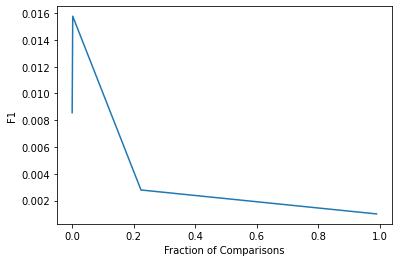

In [43]:
# Plots F1* with respect to fraction of comparisons
plt.plot(F_c, f1_lsh)
plt.ylabel('F1')
plt.xlabel('Fraction of Comparisons')

# Bootstrapping LSH and Classification 

In [22]:
# Function that runs one boorstrap each time
def run_boot(df_total):
    # Get train data (boot) of 63% with replacement, rest is test data (oob)
    df_boot = df_total.sample(frac=0.63, replace=True, random_state=42)
    df_oob = df_total.merge(df_boot, how = 'outer', indicator=True).loc[lambda x : x['_merge']=='left_only']
    df_boot = df_boot.reset_index(drop=True)
    df_oob = df_oob.reset_index(drop=True)

    # Innder function that makes candidate pairs for train and test set and gives F1* 
    def all_preprocess(df_prep):
        k = 3  # Set shingle size

        # Get shingles
        titles = df_prep['titlefeatures']
        shingles = []
        for title in titles:
            shingles.append(get_shingles(title, k))

        # Get vocabulary
        vocab = get_vocab(shingles)

        # Get binary vector
        shingles_1hot = []
        for shingle_set in shingles:
            shingles_1hot.append(get_binary_vector(shingle_set, vocab))
        # make binary vectors of each title and feature values
        shingles_1hot = np.stack(shingles_1hot)
        shingles_1hot.shape
        
        # Get minhash funchtions 
        hhash = minhashing(vocab, 100)

        signatures = []
        # Get signatures 
        for vector in shingles_1hot:
            signatures.append(get_signature(hhash, vector))
            
        signatures = np.stack(signatures)
        signatures.shape

        # Get buckets from LSH
        buckets = get_lsh_buckets(signatures, 25) # Change to 25 to run the second round of bootstraps
        # Get candidate pairs from buckets
        candidates = get_candidates(buckets, df_prep)
        print(f'number of cadidate pairs: {len(candidates)}') #Prints first the number of candidate pairs of the boot then oob

        # Get candidate pair dataframe for classification 
        data_candidates = []
        for c in candidates:
            r = {"pair": c,
                 "model_id0": df_prep.at[c[0], 'model_id'],
                 "model_id1": df_prep.at[c[1], 'model_id'],
                 "shop0": df_prep.at[c[0], 'shop'],
                 "shop1": df_prep.at[c[1], 'shop'],
                 "title0": df_prep.at[c[0], 'title'],
                 "title1": df_prep.at[c[1], 'title'],
                 "titlefeature0": df_prep.at[c[0], 'titlefeatures'],
                 "titlefeature1": df_prep.at[c[1], 'titlefeatures'],
                 "duplicate": (df_prep.at[c[0], 'model_id'] == df_prep.at[c[1], 'model_id'])}
            data_candidates.append(r)
        df_candidates = pd.DataFrame(data_candidates)
        
        # To get F1*-score
        nc = len(candidates)
        unique_id = len(set(df_prep['model_id']))
        n_obs = len(df_prep)
        n_dup = n_obs - unique_id
        dt = df_candidates['duplicate'].value_counts()[1]
        pc = dt/n_dup
        pq = dt/nc
        f1_star = (2*pc*pq)/(pc+pq)
        
        df_candidates['jac'] = df_candidates[['titlefeature0', 'titlefeature1']].apply(lambda x: Jac(x[0], x[1], vocab), axis=1)
        df_candidates['cos'] = df_candidates[['titlefeature0', 'titlefeature1']].apply(lambda x: Cos(x[0], x[1], vocab), axis=1)    

        return df_candidates, f1_star
    
    # Calls inner function 
    df_boot_candidates, f1_boot = all_preprocess(df_boot)
    df_oob_candidates, f1_oob = all_preprocess(df_oob)
    
    print(f"This is the f1 of lsh for boot: {f1_boot}")
    print(f"This is the f1 of lsh for oob: {f1_oob}")
    
    # Define train and test set 
    X_train = df_boot_candidates[['jac', 'cos']]
    y_train = df_boot_candidates['duplicate']
    
    X_test = df_oob_candidates[['jac', 'cos']]
    y_test = df_oob_candidates['duplicate']
    
    # Oversample the minority class, the duplicates
    oversample = RandomOverSampler(sampling_strategy='auto')
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Makes model
    lr = LogisticRegression(random_state=0).fit(X_over, y_over)

    # GridSearch for hyperparamater C
    param_grid_lr = {'C': np.logspace(-3, 3, 7)}
    grid_lr = GridSearchCV(lr, param_grid_lr, cv=5) 
    fitgrid_lr = grid_lr.fit(X_over, y_over)
    y_pred_lr = grid_lr.predict(X_over)
    y_pred_lr_test = grid_lr.predict(X_test)

    # Prints classification report
    print("Classification metrics:")
    print(classification_report(y_test, y_pred_lr_test, digits=5))
    
    # Return 3 F1-scores
    return f1_score(y_test, y_pred_lr_test), f1_boot, f1_oob



In [19]:
# 5 bootstraps for b=50
f1_run1_b50 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run2_b50 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run3_b50 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run4_b50 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run5_b50 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])

number of cadidate pairs: 58155
number of cadidate pairs: 63439
This is the f1 of lsh for boot: 0.0033500837520938024
This is the f1 of lsh for oob: 0.0024230599786015483
Classification metrics:
              precision    recall  f1-score   support

       False    0.99986   0.88496   0.93891     63362
        True    0.00938   0.89610   0.01856        77

    accuracy                        0.88498     63439
   macro avg    0.50462   0.89053   0.47873     63439
weighted avg    0.99866   0.88498   0.93779     63439



In [20]:
# Print all F1-scores of the 5 bootstraps for b=50
print(f1_run1_b50)
print(f1_run2_b50)
print(f1_run3_b50)
print(f1_run4_b50)
print(f1_run5_b50)

(0.018560860793544052, 0.0033500837520938024, 0.0024230599786015483)


In [25]:
# 5 bootstraps for b=25 ----> first set in function b = 25
f1_run1_b25 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run2_b25 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run3_b25 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run4_b25 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])
f1_run5_b25 = run_boot(df[['model_id', 'shop', 'title', 'titlefeatures']])

number of cadidate pairs: 525
number of cadidate pairs: 782
This is the f1 of lsh for boot: 0.0045662100456621
This is the f1 of lsh for oob: 0.011123470522803115
Classification metrics:
              precision    recall  f1-score   support

       False    0.99867   0.96782   0.98301       777
        True    0.13793   0.80000   0.23529         5

    accuracy                        0.96675       782
   macro avg    0.56830   0.88391   0.60915       782
weighted avg    0.99317   0.96675   0.97823       782



In [26]:
# Print all F1-scores of the 5 bootstraps for b=25
print(f1_run1_b25)
print(f1_run2_b25)
print(f1_run3_b25)
print(f1_run4_b25)
print(f1_run5_b25)

(0.2352941176470588, 0.0045662100456621, 0.011123470522803115)
